In [1]:
import patsy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('credit_scoring.csv', parse_dates = ['data_ref'])

df['tempo_emprego'].fillna(-1, inplace=True)
df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,1,F,True,True,0,Assalariado,Secundário,Casado,Casa,49,8.605479,2.0,1916.54,0
1,2015-01-01,2,M,True,False,0,Empresário,Secundário,União,Casa,60,6.953425,2.0,2967.25,0
2,2015-01-01,3,F,True,False,0,Empresário,Secundário,Casado,Casa,28,0.682192,2.0,340.96,0
3,2015-01-01,4,F,False,True,0,Assalariado,Superior completo,Casado,Casa,60,1.879452,2.0,4903.16,0
4,2015-01-01,5,F,False,False,0,Empresário,Secundário,Casado,Casa,47,8.438356,2.0,3012.60,0


#### Bases de desenvolvimento, validação e *out-of-time*

Vamos separar as bases que utilizaremos para desenvolver o modelo (train), *tunar* o modelo (test) e avaliar a performance (val).

In [3]:
# Selecionar meses de 2016 para validação
df_val = df[df['data_ref'] >= datetime(2016,1,1)].copy()

# Selecionar meses de 2015 para treinamento e teste
df = df[df['data_ref'] < datetime(2016,1,1)]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Quantidade de linhas no treino:    ',df_train.shape[0])
print('Quantidade de linhas no teste:     ',df_test.shape[0])
print('Quantidade de linhas na validação: ',df_val.shape[0])

Quantidade de linhas no treino:     42000
Quantidade de linhas no teste:      18000
Quantidade de linhas na validação:  15000


In [4]:
equacao = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao 
            + estado_civil + tipo_residencia + idade + qt_pessoas_residencia'''
           
y_train, X_train = patsy.dmatrices(equacao, data=df_train)
y_test, X_test = patsy.dmatrices(equacao, data=df_test)
y_val, X_val = patsy.dmatrices(equacao, data=df_val)


## Métricas para problemas de classificação

Vamos avaliar o desempenho do random forest nas base de treinamento, teste e validação. Vamos avaliar a partir das seguintes métricas KS, Gini, AUC e Acurácia.

#### Função para calcular o desempenho

Para facilitar essas comparações, vamos construir uma função para calcular todos esses indicadores. É interessante colocar valores padrão para os parâmetros da função, assim, vamos poder indicar somente a base de dados para rodar a função com os valores padrão dela.

In [5]:
# Calcular o Gini
def calcula_gini(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)
    
    #Gini
    gini = 2*auc -1
    return gini


def print_metricas(dados, 
                  PD = 'PD', 
                  CLASSE_PRED = 'classe_predita', 
                  RESP = 'mau'):
    
    #Acuracia
    acc = accuracy_score(dados[RESP], dados[CLASSE_PRED])

    #AUC
    auc = roc_auc_score(dados[RESP], dados[PD])
    
    #Gini
    gini = 2*auc-1
    
    #KS
    ks = ks_2samp(dados.loc[dados[RESP] == 1, PD], 
                  dados.loc[dados[RESP] != 1, PD]).statistic

    print('KS:       {0:.2f}%'.format(ks*100))
    print('AUC:      {0:.2f}%'.format(auc*100))
    print('GINI:     {0:.2f}%'.format(gini*100))
    print('Acurácia: {0:.2f}%\n'.format(acc*100))
    
    return None

## Random Forest no scikitlearn

In [6]:
%%time

clf = RandomForestClassifier(n_estimators=600, 
                             max_depth=13,
                             min_samples_leaf=41)

clf.fit(X_train,y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:,1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:,1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:,1]

print_metricas(dados = df_train)
print_metricas(dados = df_test)
print_metricas(dados = df_val)

KS:       22.06%
AUC:      65.59%
GINI:     31.18%
Acurácia: 93.03%

KS:       16.10%
AUC:      60.52%
GINI:     21.03%
Acurácia: 93.16%

KS:       16.78%
AUC:      60.53%
GINI:     21.06%
Acurácia: 92.88%

CPU times: user 18.6 s, sys: 25.9 ms, total: 18.6 s
Wall time: 18.7 s


# 2. Hiperparâmetros

Hiperparâmetros são parâmetros que controlam como o algoritmo é otimizado. O número de árvores por exemplo é um hiperparâmetro da *random forest*.

Qual é o melhor conjunto de hiperparâmetros para o *random forest*? Esta é a pergunta de ouro :) Mas felizmente há um método estruturado para se buscar esses hiperparâmetros, esse método é conhecido como *grid search* (ou busca em grade).

Vamos exemplificar essa busca de modo simplificado abaixo, buscando parâmetros um a um, em seguida variando mais de um ao longo de uma *grade* como o nome do método sugere.

## Gridsearch 1 - variando o número de árvores

Vamos estabelecer parâmetros fixos de ```max_depth``` e ```min_samples_leaf```, e variar o número de árvores, e avaliar a cada rodada o desempenho do modelo.

In [7]:
grid = list(range(100, 1001, 150))
grid

[100, 250, 400, 550, 700, 850, 1000]

In [8]:
for num_arvores in grid:
    print(num_arvores)

100
250
400
550
700
850
1000


In [9]:
%%time
lista_gini_test=[]
lista_gini_train=[]

grid = list(range(100, 1001, 150))

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5)
    
    clf.fit(X_train,y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)


CPU times: user 1min 27s, sys: 263 ms, total: 1min 28s
Wall time: 1min 28s


In [10]:
grid = list(range(100, 1001, 150))
grid

[100, 250, 400, 550, 700, 850, 1000]

In [ ]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=250,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=400,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=550,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=700,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=850,
                             max_depth=10,
                             min_samples_leaf=5)

clf = RandomForestClassifier(n_estimators=1000,
                             max_depth=10,
                             min_samples_leaf=5)

In [10]:
%%time
lista_gini_test=[]
lista_gini_train=[]

grid = list(range(100, 1001, 150))

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5,
                                 n_jobs=-1)
    
    clf.fit(X_train,y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)


CPU times: user 3min 39s, sys: 3.43 s, total: 3min 43s
Wall time: 42.2 s


In [11]:
zip_gini_train = zip(list(range(100, 1001, 150)), lista_gini_train)
zip_gini_test = zip(list(range(100, 1001, 150)), lista_gini_test)

dict_gini_train = dict(zip_gini_train)
dict_gini_test = dict(zip_gini_test)
print(dict_gini_train)

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)
print(series_gini_train)

{100: 0.35709163030547586, 250: 0.3595322451940566, 400: 0.3603749207669078, 550: 0.35994984937526064, 700: 0.36237977058893334, 850: 0.36373107336489663, 1000: 0.36124071496319066}
100     0.357092
250     0.359532
400     0.360375
550     0.359950
700     0.362380
850     0.363731
1000    0.361241
dtype: float64


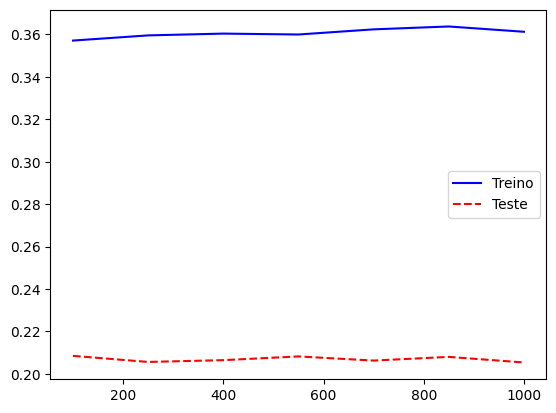

In [12]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()


In [13]:
grid = list(range(1, 1000, 20))
print(grid)

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981]


In [14]:
len(grid)

50

In [15]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(1, 1000, 20))
print(grid)

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5,
                                 n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981]
CPU times: user 25min 5s, sys: 23.8 s, total: 25min 29s
Wall time: 4min 50s


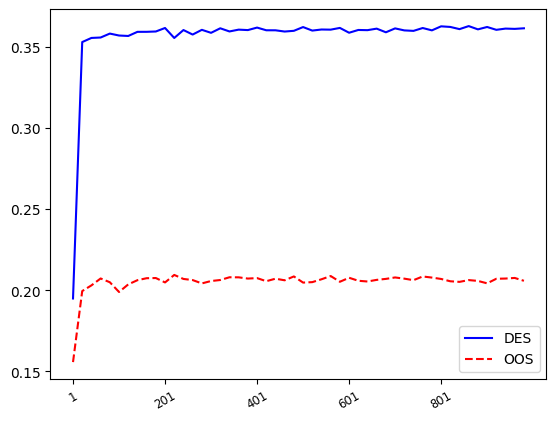

In [16]:
fig, ax = plt.subplots()
ax.plot(lista_gini_train, '-b', label='DES')
ax.plot(lista_gini_test, '--r', label='OOS')

leg = ax.legend()
ticks = ax.set_xticks(range(0, len(grid), 10))
labels = ax.set_xticklabels(labels=grid[::10], rotation=30, fontsize='small');

## Função GridSearchCV

In [17]:
list(range(1, 1001, 500))

[1, 501]

In [18]:
from sklearn.model_selection import GridSearchCV


In [19]:
%%time
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(1, 1001, 500))
}

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 5)

grid_rf.fit(X_train, y_train)

/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

CPU times: user 46.6 s, sys: 89.1 ms, total: 46.7 s
Wall time: 46.7 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [5],
                         'n_estimators': [1, 501]},
             scoring='accuracy')

In [20]:
grid_rf.cv_results_['params']

[{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 1},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 501}]

In [21]:
print(grid_rf.best_estimator_)


RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=501)


In [22]:
# print os melhores parametros
print(grid_rf.best_estimator_)

# 
print(grid_rf.best_estimator_.score(X_test, y_test))
print(grid_rf.score(X_test, y_test))



RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=501)
0.9316111111111111
0.9316111111111111


## Randomizedsearch 2 - Variando mínimo de observações por folha

Agora vamos variar apenas ```min_samples_leaf```.

In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': list(range(2,5000,100)),
    'n_estimators': [800]
}

grid_rf = RandomizedSearchCV(n_iter = 5,
                             estimator = rf,
                             param_distributions = params,
                             scoring = 'accuracy', 
                             cv = 3)

grid_rf.fit(X_train, y_train)

/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sos/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

CPU times: user 1min 36s, sys: 184 ms, total: 1min 36s
Wall time: 1min 36s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': [2, 102, 202, 302,
                                                             402, 502, 602, 702,
                                                             802, 902, 1002,
                                                             1102, 1202, 1302,
                                                             1402, 1502, 1602,
                                                             1702, 1802, 1902,
                                                             2002, 2102, 2202,
                                                             2302, 2402, 2502,
                                                             2602, 2702, 2802,
                                                             2902, ...],
                                        'n_estimators': [800]},
                   scoring='accuracy')

In [ ]:
grid_rf.cv_results_['params']

In [ ]:
grid_rf.cv_results_['mean_test_score']

In [ ]:
print(grid_rf.score(X_test, y_test))


## Função RandomizedSearchCV

In [27]:
params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(100, 1001, 100))
}
params

{'max_depth': [10],
 'min_samples_leaf': [5],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [28]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(100, 1001, 100))
}

grid_rf = RandomizedSearchCV(n_iter = 7,
                             estimator = rf,
                             param_distributions = params,
                             scoring = 'accuracy', 
                             cv = 3)

grid_rf.fit(X_train, y_train)

C:\Users\lucas_000\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lucas_000\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lucas_000\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lucas_000\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A co

Wall time: 3min 41s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': [5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='accuracy')

In [29]:
# extract best estimator
print(grid_rf.best_estimator_)

# to test the bestfit
print(grid_rf.score(X_test, y_test))



RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=900)
0.9316111111111111


## Gridsearch usando `for` para variar o número mínimo de observações na folha

In [24]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(2,5000,100))
print(grid)

for n_min_obs in grid:
    clf = RandomForestClassifier(n_estimators=30,
                                 max_depth=10,
                                 min_samples_leaf=n_min_obs,
                                 n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

dict_gini_train = dict(zip(list(range(2,5000,100)), lista_gini_train))
dict_gini_test = dict(zip(list(range(2,5000,100)), lista_gini_test))

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)


[2, 102, 202, 302, 402, 502, 602, 702, 802, 902, 1002, 1102, 1202, 1302, 1402, 1502, 1602, 1702, 1802, 1902, 2002, 2102, 2202, 2302, 2402, 2502, 2602, 2702, 2802, 2902, 3002, 3102, 3202, 3302, 3402, 3502, 3602, 3702, 3802, 3902, 4002, 4102, 4202, 4302, 4402, 4502, 4602, 4702, 4802, 4902]
CPU times: user 45.7 s, sys: 1.23 s, total: 47 s
Wall time: 12.5 s


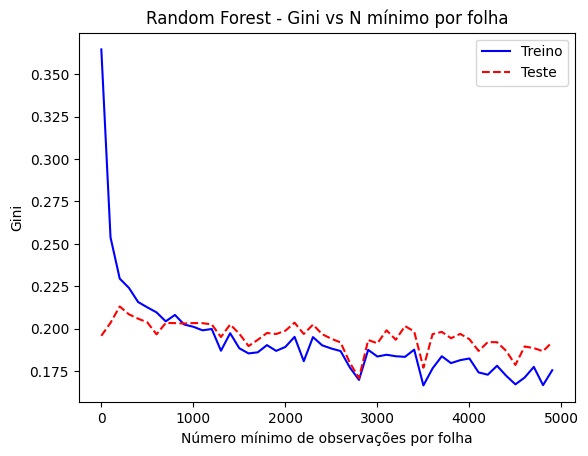

In [25]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()
ax.set_title("Random Forest - Gini vs N mínimo por folha")
ax.set_xlabel("Número mínimo de observações por folha")
ax.set_ylabel("Gini");

## Gridsearch 3 (usando `for`)  - variando a profundidade da árvore

Agora vamos fixar ```n_estimators``` e ```min_samples_leaf``` e variar ```max_depth```.

In [26]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(1,50))
print(grid)

for profundidade in grid:
    clf = RandomForestClassifier(n_estimators=30,
                                 max_depth=profundidade,
                                 min_samples_leaf=1,
                                n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

dict_gini_train = dict(zip(grid, lista_gini_train))
dict_gini_test = dict(zip(grid, lista_gini_test))

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
CPU times: user 1min 46s, sys: 1.49 s, total: 1min 48s
Wall time: 21.5 s


Text(0, 0.5, 'Gini')

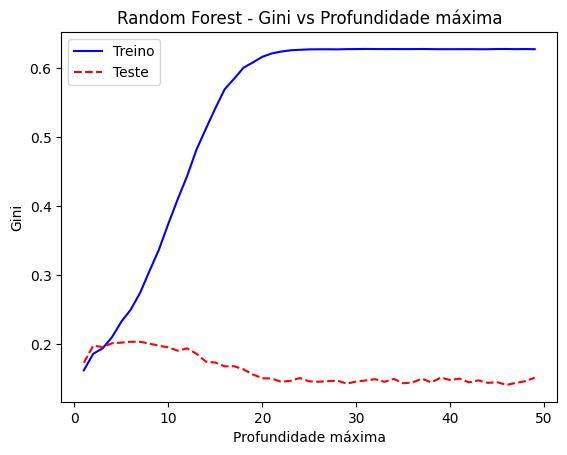

In [27]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()
ax.set_title("Random Forest - Gini vs Profundidade máxima")
ax.set_xlabel("Profundidade máxima")
ax.set_ylabel("Gini")

## Gridsearch 4 - alterar profundidade e número de observações por folha

In [28]:
%%time

lista_gini_test = []
lista_gini_train = []
lista_obs_folha = []
lista_profundidade = []

grid_profund = list(range(3, 20, 2))
grid_obs_folha = list(range(1, 30, 1))

for profundidade in grid_profund:
    for obs_folha in grid_obs_folha:
        clf = RandomForestClassifier(n_estimators=30,
                                     max_depth=profundidade,
                                     min_samples_leaf=obs_folha,
                                     n_jobs=-1)

        clf.fit(X_train, y_train.ravel())

        gini_test = calcula_gini(y_test, clf.predict_proba(X_test)[:, 1])
        gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:, 1])

        lista_gini_test.append(gini_test)
        lista_gini_train.append(gini_train)
        lista_obs_folha.append(obs_folha)
        lista_profundidade.append(profundidade)

grid_dic = {'obs_folha': lista_obs_folha, 
            'profund_max': lista_profundidade,
            'gini_dev': lista_gini_train,
            'gini_test': lista_gini_test}

grid = pd.DataFrame(grid_dic)

CPU times: user 7min 7s, sys: 7.01 s, total: 7min 14s
Wall time: 1min 32s


In [29]:
grid

,obs_folha,profund_max,gini_dev,gini_test
0,1,3,0.193276,0.197975
1,2,3,0.201536,0.198810
2,3,3,0.195512,0.200725
3,4,3,0.190639,0.198619
4,5,3,0.201999,0.202736
...,...,...,...,...
256,25,19,0.372616,0.202232
257,26,19,0.368732,0.201535
258,27,19,0.358685,0.199153
259,28,19,0.354843,0.196866


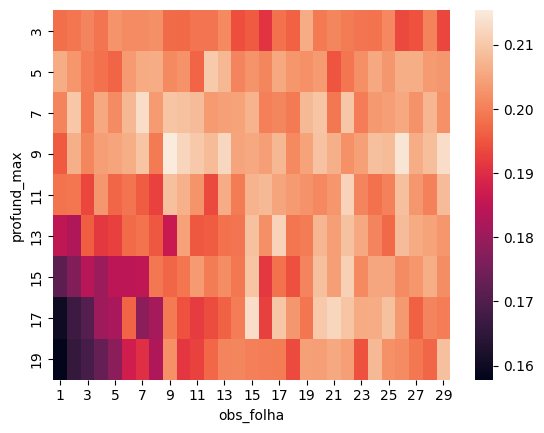

In [30]:
sns.heatmap(grid.pivot_table(index='profund_max',
                             columns='obs_folha',
                             values='gini_test',
                             aggfunc='mean'));

In [32]:
grid[(grid['obs_folha'] == 27) & (grid['profund_max'] == 13)]

,obs_folha,profund_max,gini_dev,gini_test
171,27,13,0.332136,0.205866


In [33]:
grid['gini_test'].max()

0.21544706565861071

# Tarefa 4

Defina outros 3 ou 4 hyperparametros para variar e encontre uma solução de melhores hyperparametros para o mesmo dataset utilizado na aula.